In [1]:
import numpy as np
import h5py
import json
import numpy as np
import torch.nn.functional as F
import torch.utils.data
from progress.bar import Bar
from collections import defaultdict
import pandas as pd
from collections import Counter
import seaborn as sns
import itertools
from utils import *
sns.set(font_scale=1.5, rc={'text.usetex' : True})
sns.set_style("white")

# Load metadata

In [2]:
h5 = h5py.File("data/visdial_data.h5", 'r')
js = json.load(open('data/visdial_params.json', 'r'))
ann_reader_val = DenseAnnotationsReader("data/visdial_1.0_val_dense_annotations.json")
test_ans = torch.LongTensor(h5["ans_index_val"][:].astype(int))
ndcg = NDCG()
sparse_metrics = SparseGTMetrics()

### help functions

In [3]:
def scores_norm(x):
    '''
    used in naive ensemble: normalize scores before fusing
    :param scores: scores
    :return: normalized scores
    '''
    return F.normalize(x)

In [4]:
def eval_model(scores):
    '''
    measure and print performance on the validation set
    :param scores: a visidal output on validation set
    :return: ndcg and mrr results
    '''
    ordered_options_list = scores.data.sort(dim=1, descending=True)[1] + 1
    groundtruth_rank = (ordered_options_list == test_ans.view(-1, 1)).max(dim=1)[1] + 1
    metrics = defaultdict(int)
    metrics["r1"] = float((groundtruth_rank == 1).sum()) / scores.size(0)
    metrics["r5"] = float((groundtruth_rank <= 5).sum()) / scores.size(0)
    metrics["r10"] = float((groundtruth_rank <= 10).sum()) / scores.size(0)
    metrics["mrr"] = groundtruth_rank.float().reciprocal().sum() / scores.size(0)
    metrics["mrank"] = float(groundtruth_rank.sum()) / scores.size(0)
    print('R1: {:.4f}, R5: {:.4f}, R10: {:.4f}, MRR: {:.4f}, MRank: {:.4f}\n'.format(
        metrics["r1"], metrics["r5"], metrics["r10"],
        metrics["mrr"], metrics["mrank"]))
    b = int(scores.size()[0]/10)
    scores = scores.view(b, 10, 100)
    p_acc = np.zeros(shape=(b, 100))
    r_acc = np.zeros(shape=(b, 100))
    for d in range(scores.size(0)):
        image_id = int(js[f"unique_img_val"][d][-16:-4])
        dense_annotations = ann_reader_val[image_id]
        output_true, dense_round = dense_annotations["gt_relevance"], dense_annotations["round_id"]
        dense_round -= 1
        output_predict = scores[d][dense_round]
        p_acc[d] = output_predict
        r_acc[d] = output_true
        p_acc = torch.Tensor(p_acc)
    r_acc = torch.Tensor(r_acc)
    ndcg.observe(p_acc, r_acc)
    metric = ndcg.retrieve()
    print(metric)
    return metric['ndcg'], metrics["mrr"].item()

In [5]:
js_ndcg = json.load(open('data/visdial_1.0_val_processed.json', 'r'))
def align_bert_model(path, default_model):
    '''
    Align output of Large-scale model. See issue here https://github.com/vmurahari3/visdial-bert/issues/9
    :param path: path to visdial-bert model
    :param default_model: default model for missing values
    :return: ndcg aligned model
    '''
    ndcg_model_missing = torch.Tensor(np.load(path))
    ndcg_model = torch.zeros(size=(2064, 10, 100))
    default_model = default_model.view(-1,10,100)
    mrr_i = 0
    for i, d in enumerate(js_ndcg['data']['dialogs']):
        if int(js['unique_img_val'][mrr_i][-16:-4]) == int(d['image_id']):
            #ndcg_model[mrr_i] = ndcg_model_missing[i]
            for dialog_round in range(10):
                scores = ndcg_model_missing[i][dialog_round].tolist().copy()
                gt_answer_score = scores.pop(0)
                gt_index = js_ndcg['data']['dialogs'][i]['dialog'][dialog_round]['gt_index']
                scores.insert(gt_index, gt_answer_score)
                ndcg_model[mrr_i][dialog_round] = torch.FloatTensor(scores)
        else:
            #no-answer; copy mrr result
            ndcg_model[mrr_i] = default_model[mrr_i]
            mrr_i += 1
            if int(js['unique_img_val'][mrr_i][-16:-4]) == int(d['image_id']):
                ndcg_model[mrr_i] = ndcg_model_missing[i]
        mrr_i += 1
    ndcg_model = ndcg_model.view(-1,100)
    ndcg_model = F.softmax(ndcg_model, dim=1)
    return ndcg_model

In [6]:
def scores_to_ranks(scores: torch.Tensor):
    """Convert model output scores into ranks."""
    batch_size, num_rounds, num_options = scores.size()
    scores = scores.view(-1, num_options)

    # sort in descending order - largest score gets highest rank
    sorted_ranks, ranked_idx = scores.sort(1, descending=True)

    # i-th position in ranked_idx specifies which score shall take this
    # position but we want i-th position to have rank of score at that
    # position, do this conversion
    ranks = ranked_idx.clone().fill_(0)
    for i in range(ranked_idx.size(0)):
        for j in range(num_options):
            ranks[i][ranked_idx[i][j]] = j
    # convert from 0-99 ranks to 1-100 ranks
    ranks += 1
    ranks = ranks.view(batch_size, num_rounds, num_options)
    return ranks

# MRR models naive ensemble

## 5xFGA

In [7]:
models_dir = "models"
models = ['fga1', 'fga2', 'fga3', 'fga4', 'fga5']

In [8]:
fga_ensemble = torch.zeros(size=(20640,100))

for m in models:
    val_output = torch.Tensor(np.load(f"{models_dir}/{m}/output_scores.npy")).view(-1, 100)    
    fga_ensemble += F.softmax(val_output, dim=1).data

fga_ensemble = scores_norm(fga_ensemble)
eval_model(fga_ensemble)

R1: 0.5617, R5: 0.8615, R10: 0.9295, MRR: 0.6938, MRank: 3.3252

{'ndcg': 0.5868231058120728}


(0.5868231058120728, 0.6937740445137024)

In [9]:
mrr_bert_model = scores_norm(align_bert_model(f"{models_dir}/visdial-bert/mrr_val_scores.npy", fga_ensemble))
mrr_nsp_model = scores_norm(align_bert_model(f"{models_dir}/visdial-bert/mrr_nsp_val_scores.npy", fga_ensemble))

## LS + 5xFGA

0.0
R1: 0.5617, R5: 0.8615, R10: 0.9295, MRR: 0.6938, MRank: 3.3252

{'ndcg': 0.5868231058120728}
0.1
R1: 0.5622, R5: 0.8675, R10: 0.9403, MRR: 0.6964, MRank: 3.0443

{'ndcg': 0.6072832942008972}
0.2
R1: 0.5630, R5: 0.8728, R10: 0.9461, MRR: 0.6984, MRank: 2.9678

{'ndcg': 0.6168334484100342}
0.30000000000000004
R1: 0.5643, R5: 0.8770, R10: 0.9484, MRR: 0.7004, MRank: 2.9230

{'ndcg': 0.6225102543830872}
0.4
R1: 0.5654, R5: 0.8809, R10: 0.9490, MRR: 0.7023, MRank: 2.8924

{'ndcg': 0.6282042860984802}
0.5
R1: 0.5673, R5: 0.8852, R10: 0.9494, MRR: 0.7047, MRank: 2.8654

{'ndcg': 0.6331562399864197}
0.6000000000000001
R1: 0.5706, R5: 0.8872, R10: 0.9493, MRR: 0.7078, MRank: 2.8482

{'ndcg': 0.6373842358589172}
0.7000000000000001
R1: 0.5753, R5: 0.8889, R10: 0.9488, MRR: 0.7115, MRank: 2.8359

{'ndcg': 0.6428819298744202}
0.8
R1: 0.5829, R5: 0.8891, R10: 0.9481, MRR: 0.7170, MRank: 2.8272

{'ndcg': 0.6479801535606384}
0.9
R1: 0.5920, R5: 0.8855, R10: 0.9452, MRR: 0.7225, MRank: 2.8478

{'n

[Text(0.5, 0, '$\\alpha$')]

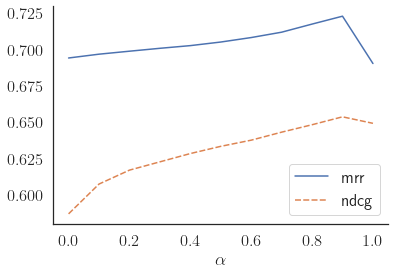

In [10]:
compare_mrr_mrr = pd.DataFrame([])
for alpha in np.arange(0,1.1,0.1):
    print(alpha)
    ndcg_result, mrr_result = eval_model(alpha*mrr_bert_model+(1-alpha)*fga_ensemble)
    row = pd.Series({'mrr': mrr_result, 'ndcg': ndcg_result}, name=alpha)
    compare_mrr_mrr = compare_mrr_mrr.append(row)
ax = sns.lineplot(data=compare_mrr_mrr)
sns.despine()
ax.set(xlabel=r'$\alpha$')

In [11]:
alpha = 0.9
best_mrr = scores_norm(alpha*mrr_bert_model+(1-alpha)*fga_ensemble)

## MRR + NDCG naive ensemble

In [12]:
ndcg_model = scores_norm(align_bert_model(f"{models_dir}/visdial-bert/val_scores.npy", best_mrr))

0.0
R1: 0.5920, R5: 0.8855, R10: 0.9452, MRR: 0.7225, MRank: 2.8478

{'ndcg': 0.653404712677002}
0.1
R1: 0.5920, R5: 0.8849, R10: 0.9450, MRR: 0.7223, MRank: 2.8663

{'ndcg': 0.6650533676147461}
0.2
R1: 0.5913, R5: 0.8845, R10: 0.9440, MRR: 0.7217, MRank: 2.8881

{'ndcg': 0.672343909740448}
0.30000000000000004
R1: 0.5905, R5: 0.8836, R10: 0.9431, MRR: 0.7208, MRank: 2.9127

{'ndcg': 0.6808881163597107}
0.4
R1: 0.5897, R5: 0.8825, R10: 0.9419, MRR: 0.7196, MRank: 2.9484

{'ndcg': 0.6892675757408142}
0.5
R1: 0.5900, R5: 0.8795, R10: 0.9403, MRR: 0.7184, MRank: 2.9934

{'ndcg': 0.6981897950172424}
0.6000000000000001
R1: 0.5880, R5: 0.8740, R10: 0.9381, MRR: 0.7153, MRank: 3.0627

{'ndcg': 0.7092170119285583}
0.7000000000000001
R1: 0.5829, R5: 0.8651, R10: 0.9328, MRR: 0.7083, MRank: 3.1890

{'ndcg': 0.7224642634391785}
0.8
R1: 0.5679, R5: 0.8424, R10: 0.9237, MRR: 0.6914, MRank: 3.4388

{'ndcg': 0.7378524541854858}
0.9
R1: 0.5283, R5: 0.7872, R10: 0.8959, MRR: 0.6480, MRank: 4.0791

{'ndc

[Text(0.5, 0, '$\\alpha$')]

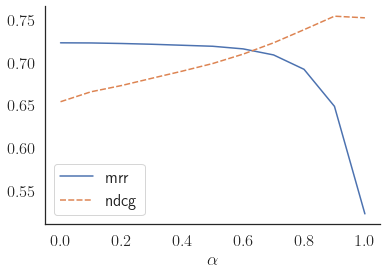

In [13]:
compare_mrr_ndcg = pd.DataFrame([])
for alpha in np.arange(0,1.1,0.1):
    print(alpha)
    ndcg_result, mrr_result = eval_model(alpha*ndcg_model + (1-alpha)*best_mrr)
    row = pd.Series({'mrr': mrr_result, 'ndcg': ndcg_result}, name=alpha)
    compare_mrr_ndcg = compare_mrr_ndcg.append(row)
ax = sns.lineplot(data=compare_mrr_ndcg)
sns.despine()
ax.set(xlabel=r'$\alpha$')

# Two-step ranks ensemble

#### Turn scores to ranks

In [14]:
fga_ranks = fga_ensemble.data.sort(dim=1, descending=True)[1].tolist()
ndcg_ranks = ndcg_model.data.sort(dim=1, descending=True)[1].tolist()
mrr_nsp_ranks = mrr_nsp_model.data.sort(dim=1, descending=True)[1].tolist()
best_mrr_ranks = best_mrr.data.sort(dim=1, descending=True)[1].tolist()

In [15]:
f1, f2, f3 = [True, True, True]
final_model = []
mrr_set_len = list()
number_of_dialogs = len(fga_ranks)
for dialog_round in range(number_of_dialogs):   
    remain_list = list()
    H = set()
    T = set()
    N = set()
    c = Counter(fga_ranks[dialog_round][:3]
                + best_mrr_ranks[dialog_round][:3]
                + mrr_nsp_ranks[dialog_round][:1])
    for k, v in c.most_common():
        if f1 and ((((k in fga_ranks[dialog_round][:3]) and
                    (k in best_mrr_ranks[dialog_round][:5])))):
            remain_list.append(k)
            H.add(k)
        elif f2 and (k == fga_ranks[dialog_round][0]
                     or k == best_mrr_ranks[dialog_round][0]):
            remain_list.append(k)
            T.add(k)
        elif f3 and (k in ndcg_ranks[dialog_round][:5]):
            remain_list.append(k)
            N.add(k)
    top_ranks = list()
    for ans_r in remain_list:
        top_ranks.append((ans_r, np.prod([l.index(ans_r) + 1 for l in [fga_ranks[dialog_round],
                                                                       best_mrr_ranks[dialog_round],
                                                                       best_mrr_ranks[dialog_round],
                                                                       mrr_nsp_ranks[dialog_round]]])))
    mrr_round_ranks = [x[0] for x in sorted(top_ranks, key=lambda x: x[1])]

    other_answers = set(list(range(100))) - set(mrr_round_ranks)

    top_others = list()
    for ans_n in other_answers:
            top_others.append((ans_n, np.sum([l.index(ans_n) + 1 for l in [ndcg_ranks[dialog_round]]*3 + 
                                                                           [best_mrr_ranks[dialog_round]]])))
    ndcg_round_ranks = [x[0] for x in sorted(top_others, key=lambda x: x[1])]
    mrr_set_len.append(len(mrr_round_ranks))
    round_ranks = mrr_round_ranks + ndcg_round_ranks
    assert len(round_ranks) == 100

    submission_ranks = list()
    for i in range(100):
        submission_ranks.append(round_ranks.index(i) + 1)
    final_model.append(submission_ranks)
final_model_scores = F.softmax(100-torch.FloatTensor(final_model), dim=1)
eval_model(final_model_scores)
print(f"mrr set size {sum(mrr_set_len)/len(mrr_set_len)}")

R1: 0.5918, R5: 0.8458, R10: 0.9078, MRR: 0.7125, MRank: 3.6215

{'ndcg': 0.7316976189613342}
mrr set size 2.9299903100775193


# Test-std json output (for EvalAI)

In [16]:
# FGA ensemble
fga_ensemble_test = torch.zeros(size=(80000,100))
for m in models:
    test_output = torch.Tensor(np.load(f"{models_dir}/{m}/output_scores_mrr.npy")).view(-1, 100)
    fga_ensemble_test += F.softmax(test_output, dim=1).data
fga_ensemble_test = fga_ensemble_test.view(-1,10,100)

temp = torch.empty(size=(8000, 100))
for i in range(8000):
    temp[i] = fga_ensemble_test[i][h5['num_rounds_test'][i] - 1]
FGA_ensemble_test = scores_norm(temp)

# MRR ensemble
MRR_bert_model_scores  = scores_norm(torch.Tensor(np.load(f"{models_dir}/visdial-bert/mrrtest_scores.npy")).view(-1, 100))
alpha = 0.9
MRR_ensemble = scores_norm(alpha*MRR_bert_model_scores+(1-alpha)*FGA_ensemble_test)

#NDCG mrr_scores
NDCG_model_scores  = scores_norm(torch.Tensor(np.load(f"{models_dir}/visdial-bert/densetest_scores.npy")).view(-1, 100))
MRR_NSP_bert_model_scores = scores_norm(torch.Tensor(np.load(f"{models_dir}/visdial-bert/mrr_nsptest_scores.npy")).view(-1, 100))

### naive ensemble

In [17]:
MRR_NDCG_ranks = scores_to_ranks((0.2*MRR_ensemble + 0.8*NDCG_model_scores).view(8000, 1, 100))

In [18]:
submission_json = list()
for i in range(8000):
    submission_json.append({
       'image_id': int(js[f"unique_img_test"][i][-16:-4]),
       'round_id': int(h5['num_rounds_test'][i]),
       'ranks': MRR_NDCG_ranks[i][0].tolist()
    })
json.dump(submission_json, open('ensemble_mrr_ndcg.json', 'w'))
print("done")

done


### Two-step ranks

In [19]:
NDCG_model_ranks = NDCG_model_scores.data.sort(dim=1, descending=True)[1].tolist()
MRR_ensemble_ranks = MRR_ensemble.data.sort(dim=1, descending=True)[1].tolist()
FGA_model_ranks = FGA_ensemble_test.data.sort(dim=1, descending=True)[1].tolist()
MRR_NSP_bert_model_ranks = MRR_NSP_bert_model_scores.data.sort(dim=1, descending=True)[1].tolist()

In [20]:
f1, f2, f3 = True, True, True
final_rank = []
number_of_dialogs = len(MRR_ensemble_ranks)
for dialog_round in range(number_of_dialogs):   
    remain_list = list()
    H = set()
    T = set()
    N = set()
    c = Counter(FGA_model_ranks[dialog_round][:10]
                + MRR_ensemble_ranks[dialog_round][:10]
                + MRR_NSP_bert_model_ranks[dialog_round][:1])
    for k, v in c.most_common():
        if f1 and ((((k in FGA_model_ranks[dialog_round][:3]) and
                    (k in MRR_ensemble_ranks[dialog_round][:5])))):
            remain_list.append(k)
            H.add(k)
        elif f2 and (k == FGA_model_ranks[dialog_round][0]
                     or k == MRR_ensemble_ranks[dialog_round][0]):
            remain_list.append(k)
            T.add(k)
        elif f3 and (k in NDCG_model_ranks[dialog_round][:5]):
            remain_list.append(k)
            N.add(k)
   
    top_ranks = list()
    for ans_r in remain_list:
        top_ranks.append((ans_r, np.prod([l.index(ans_r) + 1 for l in [FGA_model_ranks[dialog_round],
                                                                       MRR_ensemble_ranks[dialog_round],
                                                                       MRR_ensemble_ranks[dialog_round],
                                                                       MRR_NSP_bert_model_ranks[dialog_round]]])))
    mrr_round_ranks = [x[0] for x in sorted(top_ranks, key=lambda x: x[1])]

    other_answers = set(list(range(100))) - set(mrr_round_ranks)

    top_others = list()
    for ans_n in other_answers:
        top_others.append((ans_n, np.sum([l.index(ans_n) + 1 for l in [NDCG_model_ranks[dialog_round],
                                                                       NDCG_model_ranks[dialog_round],
                                                                       NDCG_model_ranks[dialog_round],
                                                                       MRR_ensemble_ranks[dialog_round]]])))
    ndcg_round_ranks = [x[0] for x in sorted(top_others, key=lambda x: x[1])]

    round_ranks = mrr_round_ranks + ndcg_round_ranks
    submission_ranks = list()
    for i in range(100):
        submission_ranks.append(round_ranks.index(i) + 1)
    assert len(round_ranks) == 100
    final_rank.append({
       'image_id': int(js[f"unique_img_test"][dialog_round][-16:-4]),
       'round_id': int(h5['num_rounds_test'][dialog_round]),
       'ranks': submission_ranks
    })
json.dump(final_rank, open('two_step.json', 'w'))
print("done")

done
